In [31]:
import numpy as np

from scipy.optimize import minimize, Bounds
from scipy.constants import hbar, c, m_e, e, alpha

from matplotlib import pyplot as plt

data = np.genfromtxt("./data.csv", delimiter=",")[1::] # Exclude headers

THETA = data[:,0] / 180.0 * np.pi # radians
Y = data[:,1] * 1e-31 # m^2/sr
ERROR = data[:,2] * 1e-31 # m^2/sr

E = 250e6 * e
A = 40
Z = 20

In [105]:
def rho_ch(r, X):
    (rho0, a, b) = X
    return rho0 / (1 + np.exp((r-a)/b))

def ch_dens(rho_ch):
    r = np.linspace(0, 8e-15, 1000)
    integrand = r**2 * rho_ch(r)
    integral = np.trapz(integrand, x=r)
    return 4 * np.pi / e * integral

def rms_radius(rho_ch):
    r = np.linspace(0, 8e-15, 1000)
    
    integrad = r**4 * rho_ch(r)
    integral = np.trapz(integrand, x=r)
    return np.sqrt(4*np.pi/(Z*e)) * integral

def X_nuc_to_SI(X_nuc):
    (rho0, a, b) = X_nuc
    rho0 *= e / 1e-45
    a *= 1e-15
    b *= 1e-15
    return (rho0, a, b)

def beta(E, m):
    # Calculate beta = v/c from relativistic total energy
    E0 = m * c**2
    return np.sqrt(1-(E0/E)**2)

def cs_rutherford(Z, E, theta):
    return ((Z * alpha * hbar * c) / (2 * beta(E, m_e)**2 * E * np.sin(theta/2)**2))**2

def cs_mott(Z, E, theta):
    correction = 1 - beta(E,m_e)**2 * np.sin(theta/2)**2
    return cs_rutherford(Z, E, theta) * correction


def form_factor(rho_Ch, q2, Z):
    N = 1000
    r = np.linspace(0, 8, N) * 1e-15
    
    result = np.zeros_like(q2)
    for i, q2_val in enumerate(q2):
        q = np.sqrt(q2_val)
        integrand = r * rho_Ch(r) * np.sin(q * r / hbar)
        integral = np.trapz(integrand, x=r)
        fact = 4 * np.pi * hbar/ (Z * e * q)
        result[i] = fact * integral

    return result

def theo_cs(rho_Ch, Z, E, theta):
    p2 = (E/c)**2 - (m_e*c)**2
    q2 = 4 * p2 * np.sin(theta/2)**2
    F2 = form_factor(rho_Ch, q2, Z)**2

    return F2 * cs_mott(Z, E, theta)

def chi2(X_nuc):
    X = X_nuc_to_SI(X_nuc)
    
    epsilon = 1e-6
    diff = theo_cs(lambda r: rho_ch(r,X), Z, E, THETA) - Y
    err = np.sum((diff / ERROR)**2)
    
    constraint = ((Z - ch_dens(lambda r: rho_ch(r,X)))/epsilon)**2
    return err + constraint

In [110]:
rho0 = 0.07
a0 = 3.77
b0 = 0.538
X0 = (rho0, a0, b0)

lb = np.array([0.06, 3, 0.3])
ub = np.array([0.5, 5, 0.7])
bounds = Bounds(lb,ub)

res = minimize(chi2, X0, tol=1e-16, options={"maxiter": 1000}, bounds=bounds)
print(res)
X_star = X_nuc_to_SI(res.x)

      fun: 1187.9474137122834
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.37539190e+08, 1.98198577e+06, 1.48245781e+06])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 464
      nit: 11
     njev: 116
   status: 2
  success: False
        x: array([0.07364149, 3.780422  , 0.53937307])


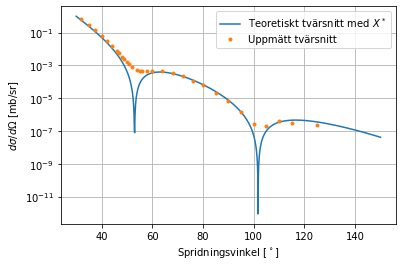

In [111]:
# Cross section for optimal X*

theta = np.linspace(30, 150, 1000) * np.pi / 180.0
plt.plot(theta * 180.0 / np.pi, 1e31 * theo_cs(lambda r: rho_ch(r, X_star), Z, E, theta))
plt.plot(THETA * 180.0 / np.pi, 1e31 * Y, '.')
plt.yscale("log")
plt.grid()
plt.xlabel("Spridningsvinkel [$^\circ$]")
plt.ylabel("$d\sigma/d\Omega$ [mb/sr]")
plt.legend(["Teoretiskt tvärsnitt med $X^*$","Uppmätt tvärsnitt"])
plt.savefig("crossections.pdf")

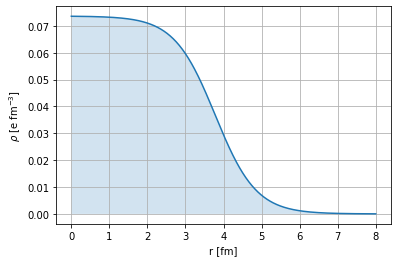

In [112]:
# Charge density for optimal X*

R = np.linspace(0, 8, 500) * 1e-15
plt.plot(R * 1e15, rho_ch(R, X_star) / e * 1e-45)
plt.fill_between(R * 1e15, rho_ch(R, X_star) / e * 1e-45, alpha=0.2)
plt.grid()
plt.xlabel("r [fm]")
plt.ylabel(r"$\rho$ [e fm$^{-3}$]")
plt.savefig("rho.pdf")

In [113]:
rms_r = np.sqrt((4 * np.pi / (Z * e)) * np.trapz(R**4 * rho_ch(R, X_star), x=R))
print(rms_r)

3.5425064843435063e-15
